In [23]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
'''
flag: data_kind: grid, hstack, vstack oder cross

output: (81x3)x512x512 oder (9x3)x512x512 oder (9x3)x512x512 oder (17x3)x512x512 <-- 9 aus hstack und restliche 8 aus vstack

transform: bleibt so, aber wir schreiben noch transform-Funktionen, auch ToTensor()

sort: nimmt liste an

shuffle: -- übernimmt dataloader

Ordnung: Von Links oben nach rechts unten.
'''

### Umgesetzt: 
**sort:** Erlaubt eine Liste. <br>
**transform:** Flag funktioniert nun. <br>
**RGB support:** Es wird jeder color channel einzeln appended $(81\times \textbf{3})$. <br>
**root_dir** Unterstützt nun einen alternativen Pfad für das Datenset. <br>
**data_kind** Unterstützt nun alle vier data_kind Eingaben.

### To-Do:
Gibt \__len__ die richtige Struktur aus? <br>
Alles auf korrekte Funktionalität getestet?

In [51]:
class LightFieldDataset:
    '''
    Dataset class for the Lightfield Dataset.
    '''
    
    def __init__(self, sort = 'training', data_kind = 'grid', root_dir = './data/', transform=None):
        '''
        Args:
            sort (string or list): What sort of data you want to load. Valid input: 'training', 'test', 'stratified', 'additional'.
            data_kind (string): What structure the data should have. Valid input: 'grid', 'hstack', 'vstack', 'cross'.
            root_dir (string, optional): the working directory with subdirectories 'training', 'test', etc.
            transform (callable, optional): Optional transform to be applied the data.
        '''

        self.root_dir = root_dir
        self.transform = transform
        self.directory_names = []
        self.images_paths = []
        self.stack_index = []
        
        if type(sort) == str:
            self.images_paths.append(os.path.join(root_dir, sort))
        else:
            for directory in sort:
                self.images_paths.append(os.path.join(root_dir, directory))
        
        # this block just stores the path of each individual scene (=grid)
        # iterates over all entered values in 'sort'.
        for images_path in self.images_paths:
            # safe all the scene names (directories) and all image names of each scene
            # iterate over all directories in images path. Each directory includes the images of *one* scene
            for filename in os.listdir(images_path):
                directory_path = os.path.join(images_path, filename)
                if os.path.isdir(directory_path):
                    if data_kind in ['grid', 'cross']:
                        self.directory_names.append(directory_path)
                    else:
                        # for data_kind hstack or vstack, we have 9 stacks per scene, so we need to call each scene
                        # 9 times in __getitem__ and also add a stack_index to know, whether images are in the same
                        # stack.
                        for i in range(9):
                            self.directory_names.append(directory_path)
                            self.stack_index.append(i)

    def __len__(self):
        '''
        Returns the lenght of the dataset (number of grid's/ hstack's/ vstack's/ crosses)
        '''
        return len(self.directory_names)
    
    def __getitem__(self, index):
        '''
        Returns a whole grid/ vstack/ hstack/ cross
        '''
        
        final_data = []
        
        if torch.is_tensor(index):
            index = index.tolist()
        
        # iterate over all files for a fixed scene (which is one directory name)
        for imagename in os.listdir(self.directory_names[index]):
            # read all images
            if imagename[0:5] == 'input':
                if data_kind == 'grid':
                    img = cv2.imread(os.path.join(directory_path, imagename))
                    # To resize all images to a specific shape, uncomment: img = cv2.resize(img, shape)
                    # append each color channel seperately
                    for color in range(3):
                        final_data.append(img[:, :, color])
                else:
                    # get the number of the image and omit the first zero for calculation reasons
                    if imagename[10:12].isdigit():
                        if imagename[10] == '0':
                            image_number = int(imagename[11])
                        else:
                            image_number = int(imagename[10:12])
                            
                        if data_kind == 'hstack' and np.floor_divide(image_number, 9) == self.stack_index[index]:
                            img = cv2.imread(os.path.join(directory_path, imagename))
                            for color in range(3):
                                final_data.append(img[:, :, color])
                                
                        if data_kind == 'vstack' and image_number % 9 == self.stack_index[index]:
                            img = cv2.imread(os.path.join(directory_path, imagename))
                            for color in range(3):
                                final_data.append(img[:, :, color])
                        
                        if data_kind == 'cross' and ((np.floor_divide(image_number, 9) == 4) or 
                                                     (image_number != 40 and image_number % 9 == 4)):
                            img = cv2.imread(os.path.join(directory_path, imagename))
                            for color in range(3):
                                final_data.append(img[:, :, color])
        
        # in the 'cross' case the images got appended from vertical to horizontal, but we swap it the other way around
        if data_kind == 'cross':
            final_data = final_data[4:13] + final_data[0:4] + final_data[13:]            
                    
        if self.transform:
            final_data = self.transform(final_data)
        
        return final_data

In [53]:
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = LightFieldDataset(sort = ['training', 'test'], data_kind = 'grid')

# dataloaders
trainloader = DataLoader(trainset, batch_size=1, shuffle=False, num_workers=2)

In [2]:
'''
Funktion zum Ansehen der Bilder. Mal drin lassen.
'''

def DataLoaderFunktion(sort = 'training'):
    '''
    valid sort inputs: training, test, stratified, additional
    '''
    final_data = []
    current_image_series = []
    images_path = os.path.join('./data/', sort)
    # iterate over all directories in images path. Each directory includes the images of *one* scene
    for filename in os.listdir(images_path):
        current_scene = {}
        directory_path = os.path.join(images_path, filename)
        if os.path.isdir(directory_path):
            # iterate over all files for a fixed directory
            for imagename in os.listdir(directory_path):
                # read all images
                if imagename[0:5] == "input":
                    img = cv2.imread(os.path.join(directory_path, imagename))
                    # To resize all images to a specific shape uncomment: img = cv2.resize(img, shape)
                    current_image_series.append(img)
                # read the parameters.cfg
                if imagename == "parameters.cfg":
                    pass # missing for now. Would need a Config Parser for it: import ConfigParser
                # read all binary masks. Note they only exist in training and stratified data.
                if sort in ['training', 'stratified']:
                    if imagename.split('.')[1] == 'png' and imagename[0:5] != "input":
                        current_scene[imagename.split('.')[0]] = cv2.imread(os.path.join(directory_path, imagename))
            current_scene['images'] = current_image_series
            final_data.append(current_scene)
    return final_data

In [3]:
train_images = DataLoaderFunktion()

In [6]:
train_images[0]['images'][0].shape

(512, 512, 3)

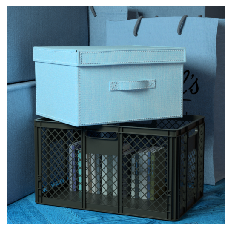

In [4]:
plt.imshow(train_images[0]['images'][0])
plt.axis('off')
plt.show()

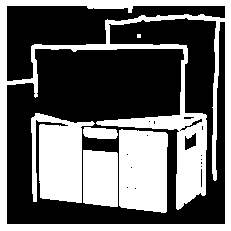

In [122]:
plt.imshow(train_images[0]['mask_discontinuities_highres'])
plt.axis('off')
plt.show()

In [123]:
test_images = DataLoader(sort = 'test')

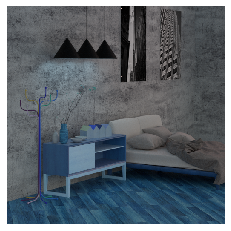

In [124]:
plt.imshow(test_images[0]['images'][0])
plt.axis('off')
plt.show()